(5, 6)
[[ 1.00000000e+00  4.80263773e+00  2.30653292e+01  1.10774420e+02
   5.32009411e+02  2.55504847e+03]
 [ 1.00000000e+00 -9.07647696e+00  8.23824340e+01 -7.47742264e+02
   6.78686543e+03 -6.16008277e+04]
 [ 1.00000000e+00 -1.40684975e+00  1.97922623e+00 -2.78447394e+00
   3.91733648e+00 -5.51110387e+00]
 [ 1.00000000e+00 -5.24766476e+00  2.75379854e+01 -1.44510116e+02
   7.58340641e+02 -3.97951746e+03]
 [ 1.00000000e+00  5.55127857e+00  3.08166937e+01  1.71072052e+02
   9.49668613e+02  5.27187502e+03]]
(101, 6)
(5, 6)
(101, 6)
history:  (754, 6)
len(history) 754
Method:  SLSQP
(101, 6)
history:  (755, 6)
len(history): 755
Method:  COBYLA
(101, 6)
history:  (755, 6)
len(history): 755


C:\Users\erick\AppData\Local\Temp\ipykernel_25124\1825652469.py:36: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x_solution = np.linalg.lstsq(a,y) #change this line
F:\Anaconda3\lib\site-packages\scipy\optimize\_minimize.py:548: RuntimeWarning: Method COBYLA does not support callback.
  warn('Method %s does not support callback.' % method, RuntimeWarning)


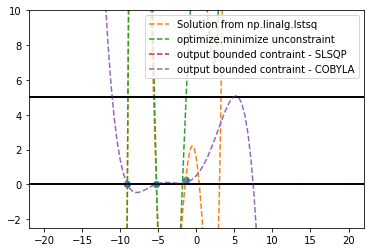

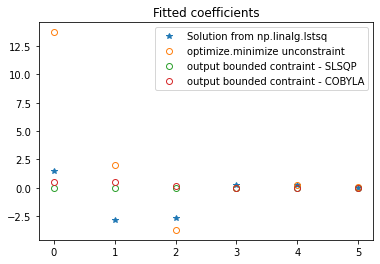

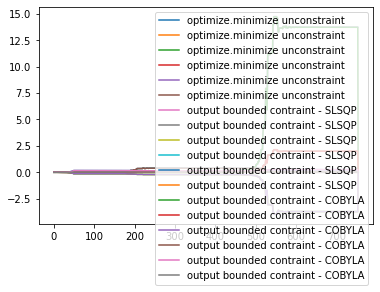

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
# from pyswa|rm import pso
from scipy import optimize

def sigmoid(x):
    return 1 / (1 + np.exp(-x))


n = 5
x = np.random.uniform(-10,10,n)
# y = sigmoid(x)
y = np.exp(x)
# x = np.array(input_x)
# y = np.array(input_y)

# y = input # next step is to set the y as a changing input, it will not be a specific function, 
               # but instead, it will be a set of data points.
plt.figure(1)
plt.plot(x,y,'o')

def make_matrix(x,k = 6):
    a = list()
    for i in range(k):
        a.append(x ** i)
    a = np.array(a).T
    print(a.shape)
    return a

Korder = 6

a = make_matrix(x,Korder)
print(a)
from scipy.linalg import solve
x_solution = np.linalg.lstsq(a,y) #change this line
# print(x_solution,b)
# plt.plot(x, y, 'o', label='Original data', markersize=10)
# plt.plot(x, a*x_solution + b, 'r', label='Fitted line')
# plt.legend()
# plt.show()

c = x_solution[0]
plt.figure(2)
plt.title('Fitted coefficients')
plt.plot(c,'*',label='Solution from np.linalg.lstsq')
xtest = np.linspace(-10,10,101)
a = make_matrix(xtest, k=Korder)
ytest = a.dot(c)
plt.figure(1)
plt.plot(xtest,ytest,'--',label='Solution from np.linalg.lstsq')

###########################################

def norm2_sq(x,A,b):
  # print('in norm2_sq',A.shape)
  return np.linalg.norm(A.dot(x) - b)**2# ||Ax - b||^2

# solve argmin || Ax - b ||^2
A = make_matrix(x,k=Korder)
history = []
def save_xk(x):
  global history
  history.append(x)

def save_xk_trust_constr(x, state):
  global history
  history.append(x)

def plot_result(coeff, history, label):
  plt.figure(1)
  xtest = np.linspace(-20,20,101)
  Atest = make_matrix(xtest,Korder)
  plt.plot(xtest,Atest.dot(coeff),'--',label=label)
  plt.legend()
  plt.axhline(y=5,c='k')
  plt.axhline(y=0,c='k')
  plt.ylim(5*np.array([-0.5,2]))
  plt.figure(2)
  plt.plot(coeff,'o',fillstyle='none',label=label)
  plt.legend()
  plt.figure(3)
  print('history: ', np.array(history).shape)
  plt.plot(np.array(history),label=label)
  plt.legend()

# # non-constraint
result = optimize.minimize(norm2_sq, x0 = np.zeros(Korder), method = 'Nelder-Mead', tol=1e-9, callback = save_xk, args = (A,y))
plot_result(result['x'],history, 'optimize.minimize unconstraint')
print('len(history)',len(history))
##################################################

# output-contraint LB < y = A*x < UB
LB = 0,
UB = 5
from scipy.optimize import NonlinearConstraint
def output(x):
  global A
  # print('in output',A.shape)
  return A.dot(x)

# names = ['trust-constr','SLSQP','COBYLA']
names = ['SLSQP','COBYLA']

for n in names:
  print('Method: ',n)
  if n == 'trust-constr':
    ybound_constr = [NonlinearConstraint(output,LB,UB)]
    cb = save_xk_trust_constr
  else:
    lower_bound = {'type': 'ineq',
              'fun' : lambda x: output(x)-LB
              }

    upper_bound = {'type': 'ineq',
              'fun' : lambda x: UB-output(x)
              }
    ybound_constr = [lower_bound,upper_bound]
    cb = save_xk
  result = optimize.minimize(norm2_sq, x0 = np.zeros(Korder), method = n,tol=1e-9, callback = cb, args = (A,y), constraints=ybound_constr)
  cf = result['x']
  plot_result(result['x'],history,'output bounded contraint - '+n)
  print('len(history):',len(history))
  # np.save('history_'+n+'.npy',np.array(history))
  # np.save('coeff_'+n+'.npy',cf)
# trust-exact
# result = optimize.minimize(norm2_sq, x0 = np.zeros(Korder), args=(), method='trust-exact', jac=None, hess=None, tol=None, callback= save_xk, options={})
# cf = result['x']
# plot_result(result['x'],history,'output bounded contraint - trust-exact')

In [9]:
n = 5
x = np.random.uniform(-10,10,n)

#### DATA SET 1 #####
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
# y = sigmoid(x)

#### DATA SET 2 #####

y = np.exp(x)

(5, 4)
[[  1.           4.08157608  16.65926327  67.99605044]
 [  1.           5.12275108  26.24257866 134.43419827]
 [  1.           6.71221104  45.05377699 302.41045908]
 [  1.           1.19761196   1.43427441   1.7177042 ]
 [  1.           2.01342185   4.05386756   8.16214555]]
(101, 4)
(5, 4)
(101, 4)


C:\Users\erick\AppData\Local\Temp\ipykernel_25124\3242709703.py:25: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x_solution = np.linalg.lstsq(a,y) #change this line
F:\Anaconda3\lib\site-packages\scipy\optimize\_minimize.py:548: RuntimeWarning: Method COBYLA does not support callback.
  warn('Method %s does not support callback.' % method, RuntimeWarning)
F:\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


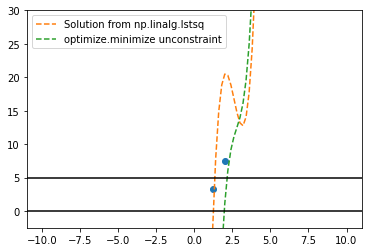

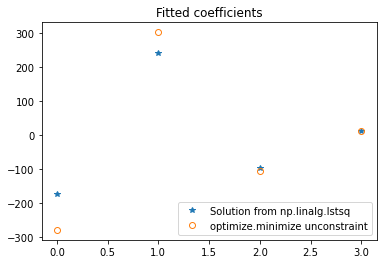

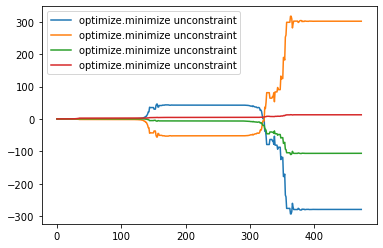

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
# from pyswarm import pso
from scipy import optimize



plt.figure(1)
plt.plot(x,y,'o')

def make_matrix(x,k = 6):
    a = list()
    for i in range(k):
        a.append(x ** i)
    a = np.array(a).T
    print(a.shape)
    return a
# a = np.vstack([x,np.ones(len(x))]).T

Korder = 4
a = make_matrix(x,Korder)
print(a)
from scipy.linalg import solve
x_solution = np.linalg.lstsq(a,y) #change this line
# print(x_solution,b)
# plt.plot(x, y, 'o', label='Original data', markersize=10)
# plt.plot(x, a*x_solution + b, 'r', label='Fitted line')
# plt.legend()
# plt.show()

c = x_solution[0]
plt.figure(2)
plt.title('Fitted coefficients')
plt.plot(c,'*',label='Solution from np.linalg.lstsq')
xtest = np.linspace(-10,10,101)
a = make_matrix(xtest, k=Korder)
ytest = a.dot(c)
plt.figure(1)
plt.plot(xtest,ytest,'--',label='Solution from np.linalg.lstsq')

###########################################

def norm2_sq(x,A,b):
  return np.linalg.norm(A.dot(x) - b)**2# ||Ax - b||^2

# solve argmin || Ax - b ||^2
A = make_matrix(x,k=Korder)
history = []
def save_xk(x):
  history.append(x)

def save_xk_trust_constr(x, state):
  history.append(x)

LB = 0
UB = 5

def plot_result(coeff, history, label):
  plt.figure(1)
  xtest = np.linspace(-10,10,101)
  Atest = make_matrix(xtest,Korder)
  plt.plot(xtest,Atest.dot(coeff),'--',label=label)
  plt.legend()
  plt.axhline(y=UB,c='k')
  plt.axhline(y=LB,c='k')
  low = -0.5 if LB == 0 else LB - np.abs(0.2*LB)
  hi = 0.5 if UB == 0 else UB + np.abs(0.2*UB)
  plt.ylim(5*np.array([low,hi]))
  plt.figure(2)
  plt.plot(coeff,'o',fillstyle='none',label=label)
  plt.legend()
  plt.figure(3)
  plt.plot(np.array(history),label=label)
  plt.legend()
# non-constraint
result = optimize.minimize(norm2_sq, x0 = np.zeros(Korder), method = 'Nelder-Mead', tol=1e-9, callback = save_xk, args = (A,y))
plot_result(result['x'],history, 'optimize.minimize unconstraint')

# 1. output-contraint -1 < y = A*x < 1
LB, UB = 0, 5
from scipy.optimize import NonlinearConstraint
def output(x):
  global A
  return A.dot(x)
# ybound_constr = NonlinearConstraint(output,0,1)
# result = optimize.minimize(norm2_sq, x0 = np.zeros(Korder), method = 'trust-constr',tol=1e-9, callback = save_xk_trust_constr, args = (A,y), constraints=[ybound_constr])
# cf = result['x']
# plot_result(result['x'],history,'ouput bounded contraint - trust-constr')

# 2. output constraint
names = ['COBYLA', 'SLSQP','trust-constr']
for n in names:
  if n == 'trust-constr':
    y_constraints = [NonlinearConstraint(output,LB,UB)]
    cb = save_xk_trust_constr
  else:
    lower_bound = {'type': 'ineq',
              'fun' : lambda x: output(x)-LB
              }

    upper_bound = {'type': 'ineq',
              'fun' : lambda x: UB-output(x)
              }
    y_constraints = [lower_bound,upper_bound]
    cb = save_xk
  result = optimize.minimize(norm2_sq, x0 = np.zeros(Korder), method = n,tol=1e-9, callback = cb, args = (A,y), constraints=y_constraints)
  cf = result['x']
  # plot_result(result['x'],history,'ouput bounded contraint - '+n)
  np.save('history_'+n+'.npy',np.array(history))
  np.save('coeff_'+n+'.npy',cf)

# data should be stored separately


(101, 4)
(101, 4)
(101, 4)


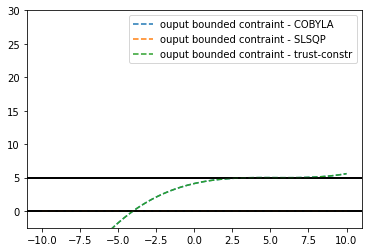

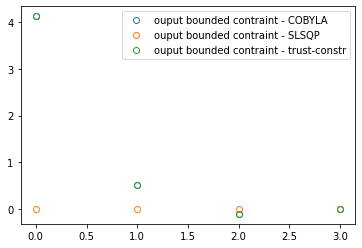

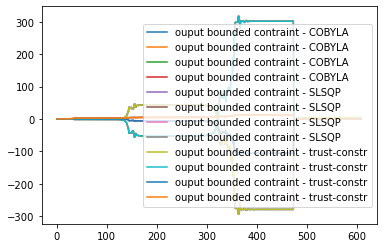

In [11]:
names = ['COBYLA', 'SLSQP','trust-constr']
for n in names:
  cf = np.load('coeff_'+n+'.npy')
  history = np.load('history_'+n+'.npy')
  plot_result(cf,history,'ouput bounded contraint - '+n)
